## Neural Network

## Importing and splitting the data

In [1]:
import csv
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw

Import the dataset. The dataset was obtained from Kaggle: https://www.kaggle.com/code/victorsabanzagil/polymers-classifier/input. The lines were read in and the molecular fingerprints and other information was put in the variable rows.

In [2]:
csvfile = 'polymers_dataset.csv'
rows = []
fingerprints = []
nonzero_count = 0
with open(csvfile, 'r') as csv_file:
     csv_reader = csv.reader(csv_file, dialect='excel', delimiter=',')
     line_count = 0
     for row in csv_reader:
          if line_count == 0:
               pass
          else:
               rows.append([val for val in row[:3]])
               fingerprints.append([int(val) for val in row[3:]])
          line_count += 1


Printing a certain molecule number with the corresponding data

In [3]:
nonzero_count = 0
print('Number of polymers: ', len(rows))
index = 411 #Change this value to see the data
print(f"Index {rows[index][0]} with SMILES {rows[index][1]}")
print('Label: ', rows[index][2])
print('Fingerprint: ',fingerprints[index])
for i in range(2048):
     if fingerprints[index][i] != 0:
          nonzero_count += 1
print('Fingerprints == 1: ', nonzero_count)

Number of polymers:  20609
Index 411 with SMILES O[C@@]([C@]([H])(CO)O[C@](O)([H])[C@@]([H])1O)([H])[C@]1([H])O[C@]([C@]([H])(CO)O[C@](O)([H])[C@]([H])1O)([H])[C@]1([H])O[C@@]([C@]([H])(CO)O[C@](O)([H])[C@@]([H])1O)([H])[C@]1([H])O[C@]([C@@]([H])(CO)O[C@@](O)([H])[C@]([H])1O)([H])[C@@]1([H])N[C@@]([C@]([H])(CO)O[C@](O)([H])[C@@]([H])1O)([H])[C@]1([H])O[C@]([C@]([H])(CO)O[C@](O)([H])[C@]([H])1O)([H])[C@]1([H])O[C@@]([C@]([H])(CO)O[C@](O)([H])[C@@]([H])1O)([H])[C@]1([H])O
Label:  oligosaccharide
Fingerprint:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 

Draw the selected molecule

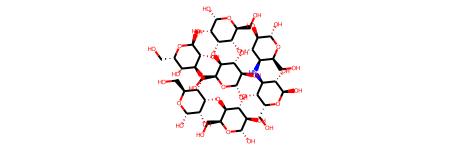

In [7]:
mol = Chem.MolFromSmiles(rows[index][1])
mol

Splitting the data into training, validation and testing data, with 80-10-10 ratio.

In [10]:
line_count = len(rows)
indices = np.arange(line_count)
indices_fin = np.arange(len(fingerprints))
# Fingerprint data
fin_rows = [fingerprints[i] for i in indices_fin[:]]
#Labels data
label = [rows[i][2] for i in range(len(rows))]
#Change strings to integers
for i in range(len(label)):
    if label[i] == 'peptide':
        label[i] = 0
    if label[i] == 'plastic':
        label[i] = 1
    if label[i] == 'oligosaccharide':
        label[i] = 2

Calculate the probabilities of the 3 labels

In [6]:
sugar = 0
plastic = 0
peptide = 0

for i in range(len(rows)):
    if rows[i][2] == 'peptide':
        peptide += 1
    elif rows[i][2] == 'plastic':
        plastic += 1
    elif rows[i][2] == 'oligosaccharide':
        sugar += 1

p_sugar = sugar / len(rows)
p_plastic = plastic / len(rows)
p_peptide = peptide / len(rows)
print(f"Probability of peptide, plastic or sugar for the label: {p_peptide:6.3f}, {p_plastic:6.3f}, {p_sugar:6.3f}.")
print('Total probability: ',p_sugar+p_plastic+p_peptide)


Probability of peptide, plastic or sugar for the label:  0.333,  0.330,  0.337.
Total probability:  1.0


## Make a Neural network to identify polymers

Importing libraries

In [25]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Prepare the data for the training, validation and testing data sets

In [26]:
NUM_CLASSES = 3
NUM_FEATURES = 2048
RANDOM_SEED = 42
X = torch.FloatTensor(fin_rows).type(torch.float)
y = torch.FloatTensor(label).type(torch.LongTensor)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=RANDOM_SEED)

Make the model with three layers: the 2048 fingerprints to a 128 hidden layer, then that layer goes to a 16 layer and then the last gives the 3 labels. The activation function used are ReLu and softmax.

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.
        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model (how many classes there are).
            hidden_units (int): Number of hidden units between layers.
        """
        super().__init__()
        self.linear_layer_stack = torch.nn.Sequential(
            torch.nn.Linear(in_features=input_features, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=128, out_features=16),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=output_features),
            torch.nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.linear_layer_stack(x)
        return x

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2048, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)

Settings for the Neural Network such as the criterion, optimizer, number of epochs

In [32]:
# Create loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [33]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

Training and validation loop

In [36]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing/Validation
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    #If accuraccy is 100%, stop the model  
    if test_acc > 99.99:
       print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 
       break
  
    # Print the losses and accuracy
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 0.70171, Acc: 99.99% | Test Loss: 0.70099, Test Acc: 100.00%


## PCA on the fingerprints polymer data.

Importing libraries

In [47]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay

[[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
[-2.57032308  1.96394576  0.29774286 ...  0.49475665  3.77882816
 -2.55655297]


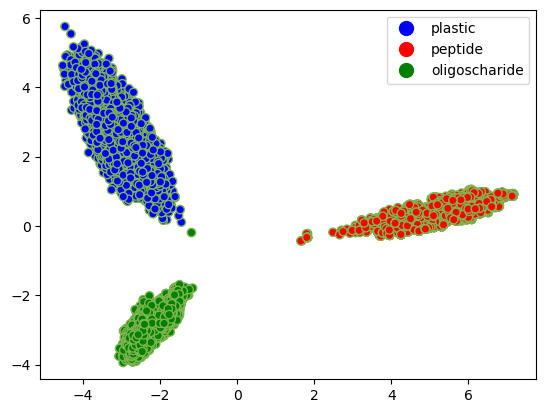

In [48]:
#Loading in the dataset
polymers = pd.read_csv(r"polymers_dataset.csv")
polymers.head()

#Data visualization
label = polymers.label.unique() #identify the labels of the values 
label_count = polymers.label.value_counts() #identify the type of label

#Converting dtaframe to float for PCA
nn_polymers=polymers.iloc[:,3:].values #decided to use .values as we are extracting specifific values fro the polymers df
print(nn_polymers)

#Importing PCA for sklearn
pca_polymers = PCA (n_components = 2) #set n_componets=2 in this case we will plot a 2D plot; recommended value for the hyperparameter

#the PCA calculation
EG = pca_polymers.fit_transform(nn_polymers) #reduce dimentions of the dataset
print(EG[:,1])
PCA1 = EG[:,0]
PCA2 = EG[:,1]

#creating a labels list and then converting the labels to colour
# Set a 3 KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(EG)
label_colour = {0: 'blue', 1: 'red', 2: 'green'}
lc = [label_colour[i] for i in X_clustered ] 

#using plotly to plot 2D scatter plot of reduded polymers=EG
plt.scatter(x = PCA1, y = PCA2, color= lc, edgecolor = '#7eb54e')

# Creating the legend for the plot
blue_patch = plt.plot([],[], marker="o", ms=10, ls="", mec=None, color='blue', label='plastic')[0]
red_patch = plt.plot([],[], marker="o", ms=10, ls="", mec=None, color='red', label='peptide')[0]
green_patch = plt.plot([],[], marker="o", ms=10, ls="", mec=None, color='green', label='oligoscharide')[0]
plt.legend(handles=[blue_patch, red_patch, green_patch], loc='best')
plt.show()

Decision tree for classification of polymers. Decision tree algorithm from sklearn module.

[Text(0.6, 0.8333333333333334, 'X[1917] <= 0.5\nentropy = 1.585\nsamples = 4122\nvalue = [1365, 1356, 1401]\nclass = peptides'),
 Text(0.4, 0.5, 'X[656] <= 0.5\nentropy = 1.0\nsamples = 2766\nvalue = [1365, 0, 1401]\nclass = peptides'),
 Text(0.2, 0.16666666666666666, 'entropy = 0.0\nsamples = 1401\nvalue = [0, 0, 1401]\nclass = peptides'),
 Text(0.6, 0.16666666666666666, 'entropy = 0.0\nsamples = 1365\nvalue = [1365, 0, 0]\nclass = plastics'),
 Text(0.8, 0.5, 'entropy = 0.0\nsamples = 1356\nvalue = [0, 1356, 0]\nclass = oligoscharides')]

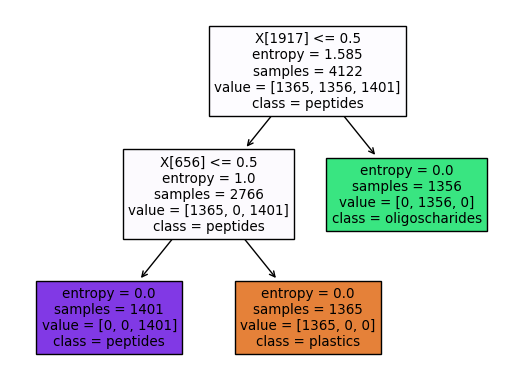

In [49]:
#Creating the values we'll use for the tree
X = polymers.iloc[:,3:].values #the fingerprint as features based on which the classification is done
Y = polymers.iloc[:,2].values #the target values

#sSplitting the data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.80, test_size=0.20, random_state=42, shuffle = True)

#Creating the tree variable
polymers_clf = tree.DecisionTreeClassifier(max_depth=3, criterion = "entropy", min_samples_split=2)

#Plotting traning dataset
polymers_clf_train = polymers_clf.fit(X_train,Y_train)

#Printing the training tree
tree.plot_tree(polymers_clf_train, class_names=['plastics', 'oligoscharides', 'peptides'], filled = True)

#Plotting testing set
polymers_clf_test = polymers_clf.fit(X_test,Y_test)
tree.plot_tree(polymers_clf_test, class_names=['plastics', 'oligoscharides', 'peptides'], filled = True)

Decision tree algorithm for classification of polymers. 

In [50]:
#class nodes
class Node:
    def __init__(self, feature=None, treshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.treshold = treshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None


#building the tree
#setting conditions for leaf nodes
class DecisionTree:
    def __init__(self, min_samples_split = 2, max_depth = 10, n_features=None):
        #the root of the tree - starting the tree
        self.root = None
        self.n_features = n_features
      #stopping conditions = 
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def fit(self, X, y):
        
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self.grow_tree(X,y) 
   
    def grow_tree(self, X, y, depth =0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        #check stopping criteria
        if (depth>=self.max_depth or n_labels ==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        feature_index = np.random.choice(n_features, self.n_features, replace=False)    
        
        
        #find best split
        best_features, best_treshold = self.best_split(X,y, feature_index)
        
        
        #make the child nodes - ak_a creating subtrees
        left_index, right_index = self.split(X[:,best_features], best_treshold)
        left = self.grow_tree(X[left_index, :], y[left_index], depth+1)
        right = self.grow_tree(X[right_index,:], y[right_index], depth+1)
        return Node(best_features, best_treshold, left, right)
        
    def best_split(self, X, y, feature_index):
            best_gain = -1
            split_index, split_treshold = None, None
            
            for feat_indx in feature_index:
                X_column = X[:,feat_indx]
                tresholds = np.unique(X_column)
                
                
                for t in tresholds:
                    gain = self.information_gain(y, X_column, t)
                    
                    if gain>best_gain:
                        best_gain = gain
                        split_index = feat_indx
                        split_treshold = t
            return split_index, split_treshold
        
    def information_gain(self,y, X_column, t):
            #parent entropy
            parent_entropy = self.entropy(y)
            
            #create children
            left_index, right_index = self.split(X_column, t)
            if len(left_index)==0 or len(right_index) == 0:
                return 0
            #caculate weighted average of child entropy
            n = len(y)
            n_l, n_r = len(left_index), len(right_index)
            e_l, e_r = self.entropy(y[left_index]), self.entropy(y[right_index])
            
            child_entropy = (n_l/n) * e_l + (n_r/n) * e_r
            information_gain = parent_entropy - child_entropy
            return information_gain
    
    def entropy (self,Y):
       class_labels = np.unique(Y)
       entropy = 0
       for i in class_labels:
           prob_class = len(Y[Y == i]) / len(Y)
           entropy += -prob_class * np.log2(prob_class)
           return entropy
        
        
    
    def split(self, X_column, split_treshold):
            left_index = np.argwhere(X_column <= split_treshold).flatten()
            right_index =  np.argwhere(X_column > split_treshold).flatten()
            return left_index, right_index
        
    def _most_common_label(self,y):
            counter  = Counter(y)
            value = counter.most_common(1)[0][0]
            return value
        
    def predict(self, X):
           return np.array([self.traverse_tree(x, self.root) for x in X])
      
          
    
    def traverse_tree(self, x, node):
        
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] <= node.treshold:
            return self.traverse_tree(x, node.left)
          
        return self.traverse_tree(x, node.right)

Running the decision tree. Accuracy is used as to measure the success of the algorithm.

In [81]:
#using float values for the decision tree
nn_polymers=polymers.iloc[:,2:].values #decided to use .values as we are extracting specifific values for the polymers df
X = nn_polymers[:,3:]
y = nn_polymers[:,0]
for i in range (len(y)):
    if y[i] == 'plastic':
        y[i] = 0 
    elif y[i] == 'peptide':
        y[i] = 1
    else:
        y[i] = 2  

#splitting the data with sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1234)
X_train.shape[0]
clf = DecisionTree()

training = clf.fit(X_train, y_train)

#clf.plot_tree(training) #print training tree
y_pred  = clf.predict(X_test).round()
print(y_pred)
print(y_test)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred)/len(y_test)
    
acc = accuracy(y_pred, y_test)
print("The accuracy is", acc)


[0 2 2 ... 1 2 1]
[0 2 2 ... 1 2 1]
The accuracy is 1.0


In [3]:
print(y_test)

NameError: name 'y_test' is not defined

In [2]:
#plotting a confusion matrix
from sklearn.metrics import confusion_matrix
def decoder(values):
     decoded = []

     for i in values:
          x = np.argmax(i)
          decoded.append(x)
     return decoded

y_pred = decoder(y_pred)
y_test = decoder(y_test)
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
disp.plot()
plt.show()

NameError: name 'y_pred' is not defined